In [88]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn as sns
import sklearn
import tensorflow
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

In [168]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [169]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [170]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [171]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [172]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [173]:
print(dat["responses"].shape)

(1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [174]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535,
 'LatOcc': 928}

In [150]:
# Data cleanup

remove_indices = np.empty(0, dtype=int)

remove_indices = np.append(remove_indices, np.where(labels[0, :] == 'person')[0])

remove_indices = np.append(remove_indices, np.where(labels[0, :] == 'fungus')[0])

remove_indices = np.append(remove_indices,  np.where(labels[0, :] == 'plant')[0])

remove_indices = np.append(remove_indices, np.where(labels[1, :] == 'instrumentality')[0])

#Remove the data
dat["stimuli"] = np.delete(dat["stimuli"], remove_indices, axis=0)

dat["responses"] = np.delete(dat["responses"], remove_indices, axis=0)

labels = np.delete(labels, remove_indices, axis=1)

print(dat["stimuli"].shape)
print(dat["responses"].shape)



(1390, 128, 128)
(1390, 8428)


Each stimulus is a 128 x 128 grayscale array:

C:\Users\sejek\AppData\Local\Temp\ipykernel_8984\24014900.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


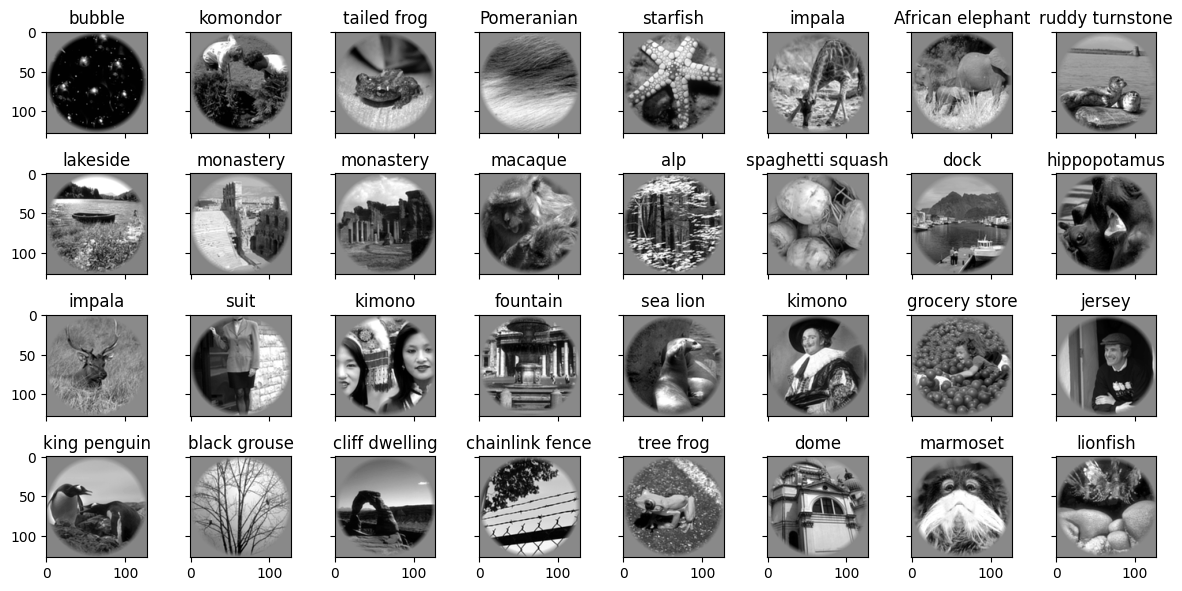

In [176]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

C:\Users\sejek\AppData\Local\Temp\ipykernel_8984\2625672689.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


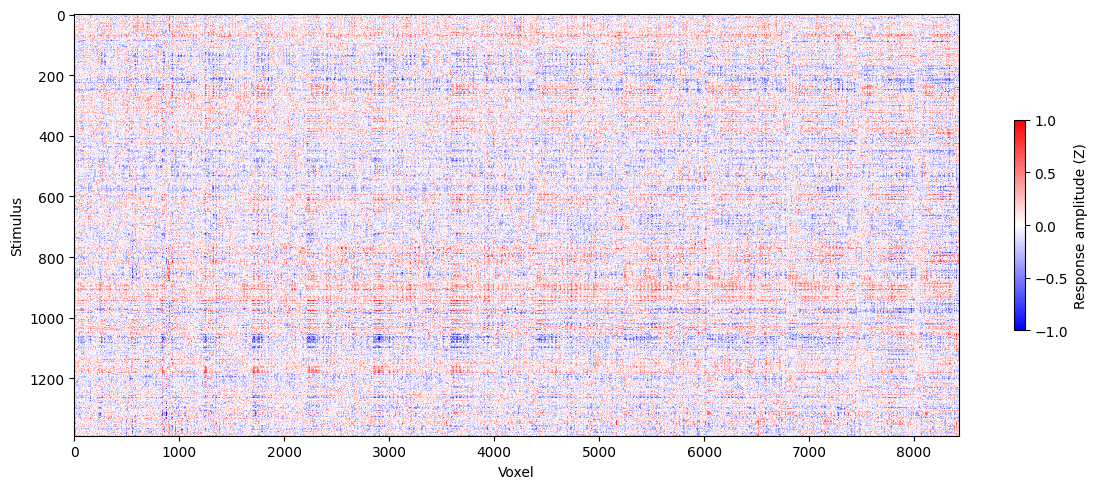

In [177]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

C:\Users\sejek\AppData\Local\Temp\ipykernel_8984\1498469230.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


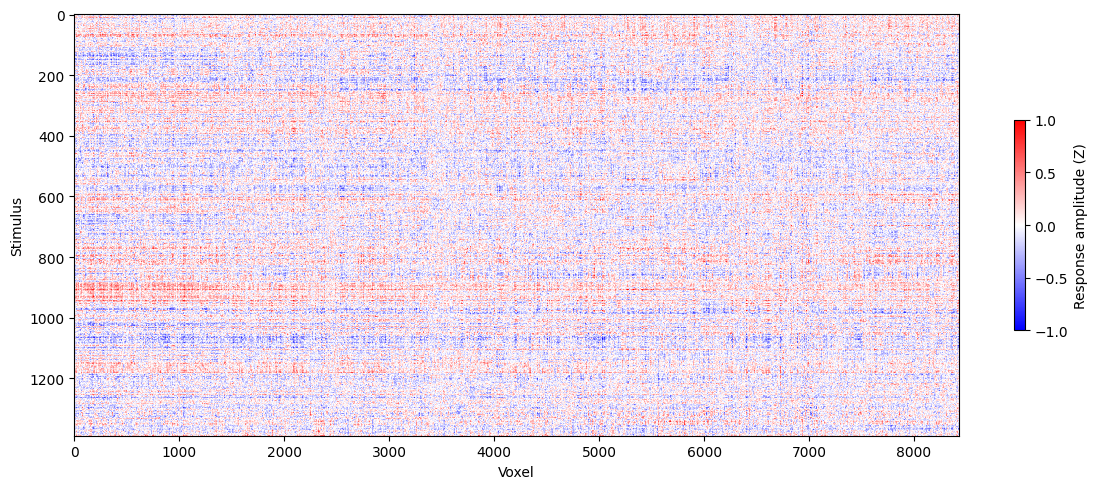

In [178]:
# Sort dat['roi'] ascending and use this order to sort dat['responses']
roi_order = np.argsort(dat['roi'])
sorted_roi = dat['roi'][roi_order]
sorted_responses = dat['responses'][:, roi_order]

# Plot the sorted responses
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(sorted_responses,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [179]:
# Split dat['responses'] by their corresponding category in labels

# Get the unique categories in labels
categories = np.unique(labels[0, :])
print("Unique categories:", categories)

# Split the responses by category (each category should have shape (num_img, 8428))
responses_by_category = [dat['responses'][labels[0, :] == category, :] for category in categories]

# Print shapes of responses_by_category
for category, category_responses in zip(categories, responses_by_category):
  print(f"Category {category} has shape {category_responses.shape}")

Unique categories: ['animal' 'artifact' 'entity' 'fruit' 'geological formation']
Category animal has shape (589, 8428)
Category artifact has shape (462, 8428)
Category entity has shape (72, 8428)
Category fruit has shape (77, 8428)
Category geological formation has shape (190, 8428)


C:\Users\sejek\AppData\Local\Temp\ipykernel_8984\1454581728.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


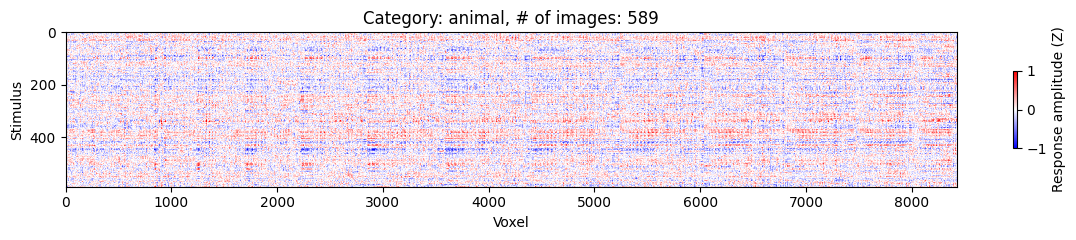

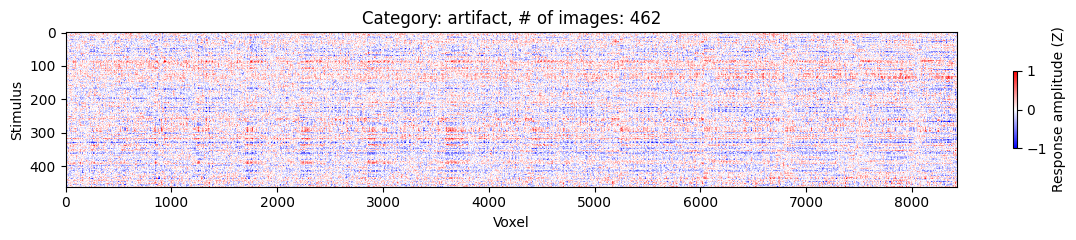

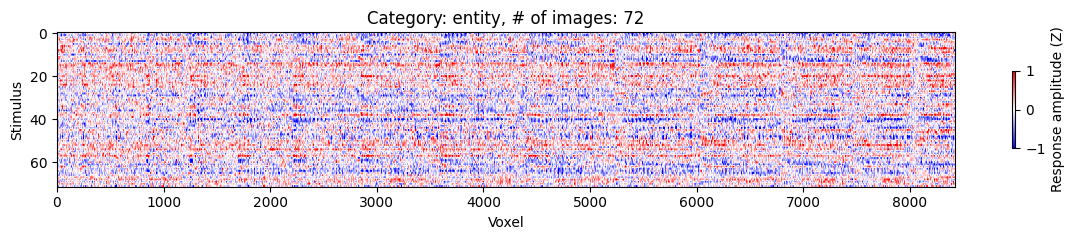

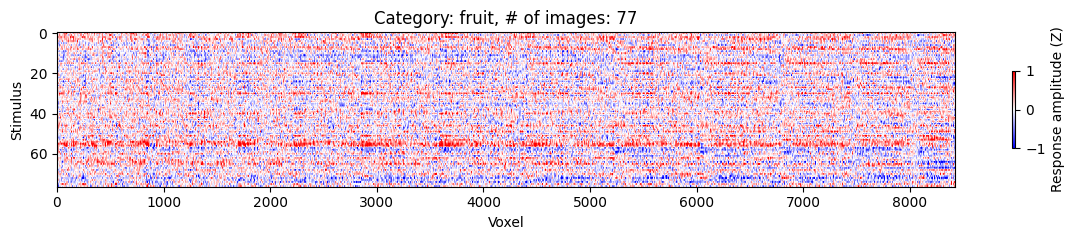

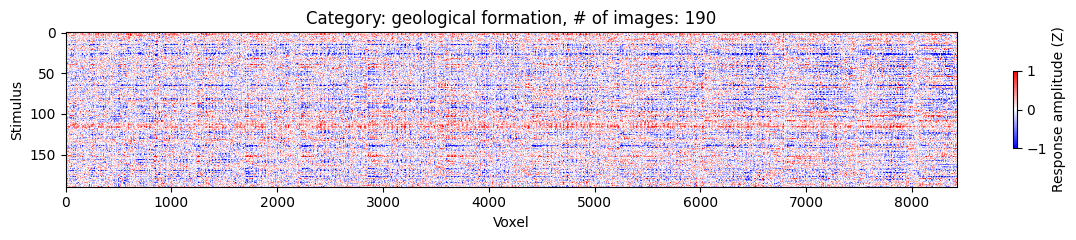

In [180]:
# Plot the responses for each category
for i in range(len(categories)):
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.set_title(f"Category: {categories[i]}, # of images: {responses_by_category[i].shape[0]}")
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(responses_by_category[i],
                        aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    fig.tight_layout()
    fig.show()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

In [181]:
# Visualize fMRI on brain map


C:\Users\sejek\AppData\Local\Temp\ipykernel_8984\3850067406.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


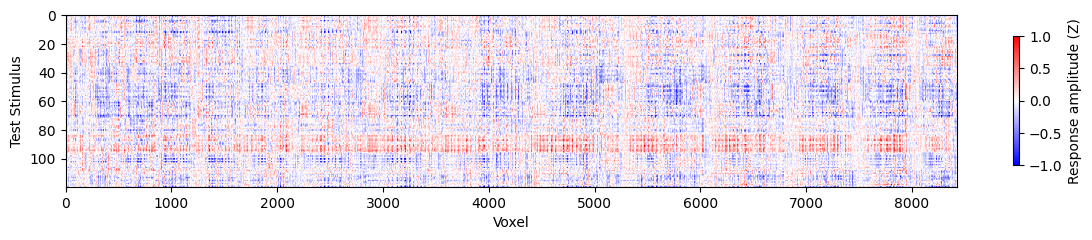

In [182]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Visualization of the means for the ROIs, compared across different stimuli of the same category

In [200]:
# Functions for plotting barplots of the different ROI's means for a specific category

def compute_roi_bins(image_index):
    responses = dat["responses"]
    rois = dat["roi"]
    roi_names_count = np.bincount(rois)[1:]

    roi_bins = [0, 0, 0, 0, 0, 0, 0]
    # For one image, go through all voxels recorded
    for i in range(len(responses[0])):
        roi_index = rois[i] - 1
        roi_bins[roi_index] += responses[image_index][i]
    for i in range(len(roi_bins)):
        roi_bins[i] /= roi_names_count[i]
    
    return roi_bins

def compute_roi_distributions_from_category(category, category_hierarchy, count):
    index = 0
    graphs_xvalues = []
    graphs_specific_labels = []
    while len(graphs_xvalues) < count:
        #print(labels[category_hierarchy][index], '/', category)
        if labels[category_hierarchy][index] == category: # category hierachy level
            graphs_xvalues.append(compute_roi_bins(index))
            graphs_specific_labels.append(labels[3][index])
        index += 1

    return graphs_xvalues, graphs_specific_labels

def barplot_roi_distribution(category, graph_xvalues, graph_specific_labels, ylim=[-0.4, 0.4], plot_rows=3, plot_cols=4):
    figure, axis = plt.subplots(plot_rows, plot_cols, figsize=(12,8))
    figure.suptitle(category)
    for ax, im, lbl in zip(axis.flat, graph_xvalues, graph_specific_labels):
        ax.set_ylim(ylim)
        ax.bar(range(len(im)), im)
        ax.set_title(lbl)
    figure.tight_layout()
    figure.show()

C:\Users\mikke\AppData\Local\Temp\ipykernel_25224\1501710227.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


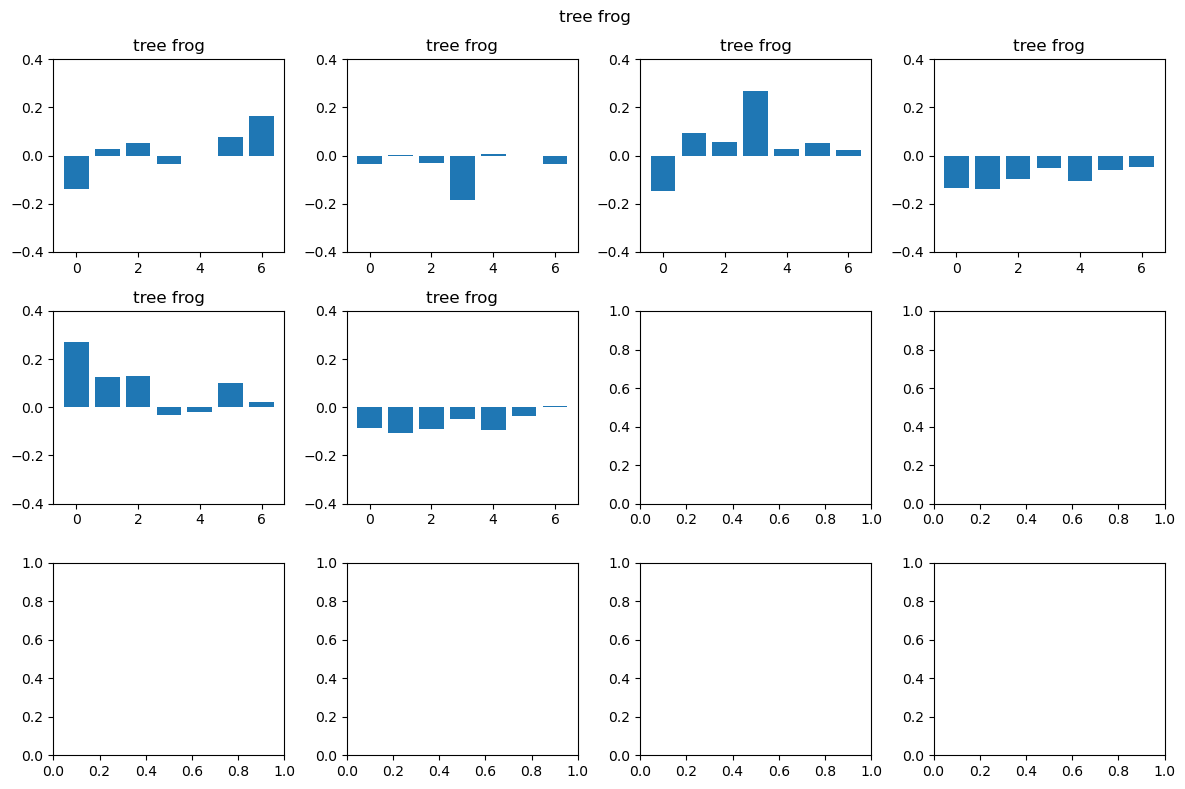

In [197]:
# Plot barplots of ROI distribution for a specified category
# Specify category name, it's hierarchy level, and how many stimili there is
category_name = 'tree frog'
category_hierarchy = 3
count = 6
roi_distributions_values, roi_distibutions_labels = compute_roi_distributions_from_category(category_name, category_hierarchy, count)
barplot_roi_distribution(category_name, roi_distributions_values, roi_distibutions_labels)

C:\Users\mikke\AppData\Local\Temp\ipykernel_25224\119951743.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


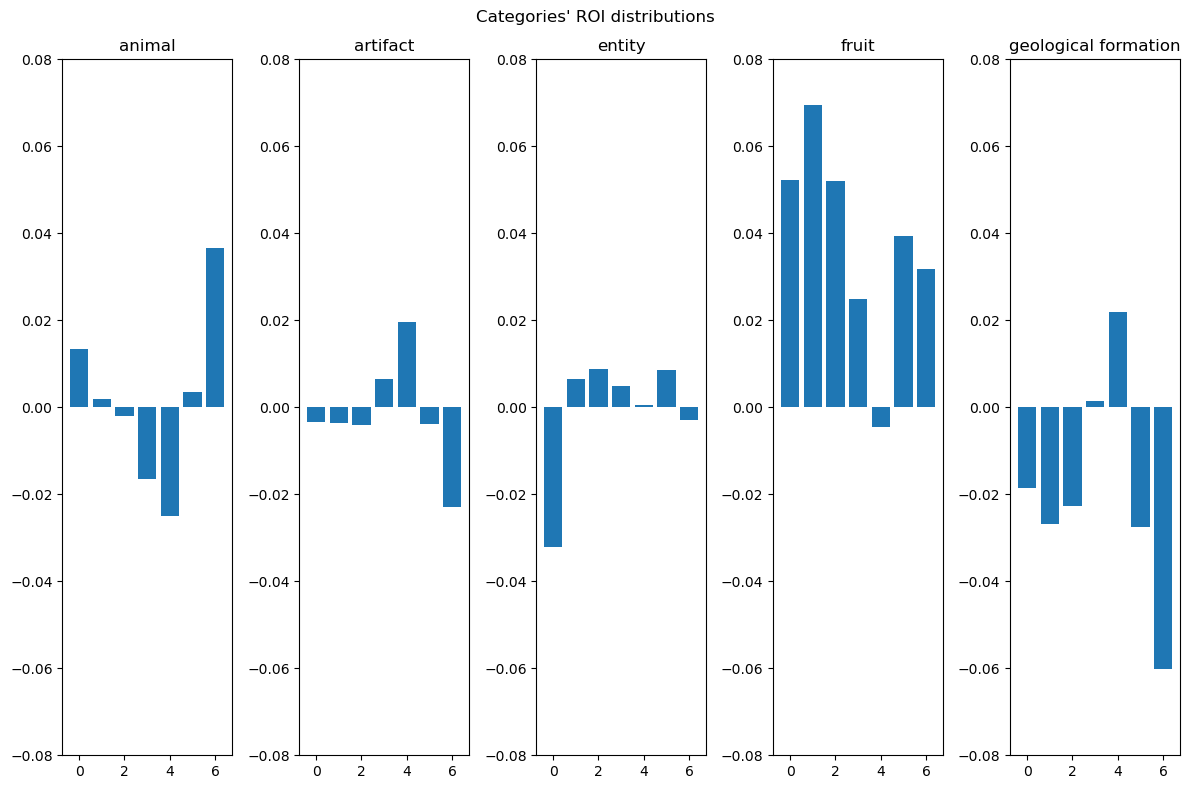

In [201]:
# Plot ROI distributions' means over all categories
# (Hardcoded to only work on category hierarchy 0 for now)

unique_labels = np.unique(labels[0, :])
# Lists to store values
total_roi_values = np.zeros((len(unique_labels), len(dat['roi_names']) - 1))
# (I didn't know how to get the sample count for each category?)
category_counts = [589, 462, 72, 77, 190]

# Loop to go through each sample 
for i in range(len(labels[0])):
    # Loop to go through each unique label (category)
    for label in range(len(unique_labels)):
        # Assign computed ROI distribution to total ROI value list in correct index (hence the previous loop)
        if labels[0][i] == unique_labels[label]:
            total_roi_values[label] += compute_roi_bins(i)

# Loop to update total ROI value list to means
for label in range(len(total_roi_values)):
    total_roi_values[label] /= category_counts[label]

barplot_roi_distribution("Categories' ROI distributions", total_roi_values, unique_labels, ylim=[-0.08, 0.08], plot_rows=1, plot_cols=5)

# Encoder model

In [143]:
# CNN model for voxel-wise encoding
class EncoderModel(nn.Module):
    def __init__(self, dimension_length, num_outputs):
        super(EncoderModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 16 * 16, 512)  # Adjust the input size based on your image dimensions
        self.fc2 = nn.Linear(512, 8428)  # Output size

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for grayscale images
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the input for fully connected layers
        x = x.view(-1, 256 * 16 * 16)  # Adjust the size based on your image dimensions

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [117]:
class Encoder():
    def __init__(self, input, output):
        self.input = input
        self.output = output
        self.losses = []
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, batch_size):
        # Seperate data
        x_train = self.input
        y_train = self.output

        # Create tensor from training data and labels
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train), torch.from_numpy(y_train)
        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        encoder_model = EncoderModel(x_train_tensor.shape[1], self.output.shape[1])
        criterion = nn.CrossEntropyLoss()

        # Optimizer
        optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True)

        return encoder_model, criterion, optimizer, train_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder = encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, labels = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()

            #if i % 100 == 0 and i != 0:
            #    print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, i, train_running_loss / 100))
            #    train_running_loss = 0.0
            
        return last_loss


    # Method for training the model fully
    def train(self, batch_size, num_epochs):
        # Setup model
        encoder_model, criterion, optimizer, train_dataloader = self.setup_model(batch_size)
        #summary(encoder_model, (14, 32, 1))
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            self.losses.append(train_running_loss)

            # Print loss value after each epoch
            print('Epoch: {} | Loss: {}'.format(epoch+1, train_running_loss))
        
            if epoch % 10 == 0 and epoch != 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title("Encoder Loss")
                plt.plot(self.losses, label="Encoder Loss")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.legend()
                # Save plot in png file if wanted
                #plt.savefig(f'loss_plotepoch{epoch+1}.png')
                plt.show()

        return encoder_model

Original input data shape: (1750, 128, 128)
Reshaped 4D input data shape: (1750, 128, 128)
Epoch: 1 | Loss: 1951.8374411039358
Epoch: 2 | Loss: 1981.0082181950552
Epoch: 3 | Loss: -4904.35581571069
Epoch: 4 | Loss: 1856.1532255079064
Epoch: 5 | Loss: nan
Epoch: 6 | Loss: nan
Epoch: 7 | Loss: nan
Epoch: 8 | Loss: nan
Epoch: 9 | Loss: nan
Epoch: 10 | Loss: nan
Epoch: 11 | Loss: nan


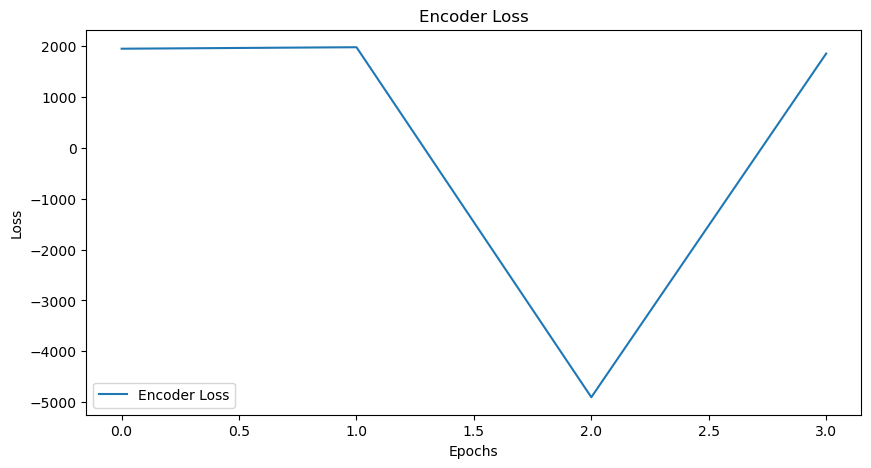

KeyboardInterrupt: 

In [144]:
input = dat['stimuli']
print('Original input data shape:', input.shape)
fourD_input = np.reshape(input, (len(input), len(input[0]), len(input[1])))
print('Reshaped 4D input data shape:', fourD_input.shape)

output = dat['responses']

encoder = Encoder(fourD_input, output)
trained_model = encoder.train(batch_size=32, num_epochs=100)